In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_SF_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
sids = np.load('../Casey_data/massMetal_GSD_IDs.npy')
nids = np.load('../Casey_data/massMetal_GND_IDs.npy')

In [549]:
len(set(nids)) #+ len(set(nids))

31

In [598]:
nids[27]

24221

In [627]:
idx =32

field='GND'
gid = nids[idx]

if field[1] == 'N':
    pre = 'N'
else:
    pre = 'S'

Gs = Gen_SF_spec(field, gid, 1,g102_lims=[8200, 11300], g141_lims=[11200, 16000])

fp = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*{0}*/*{1}*'.format(pre, gid))

subfield = fp[0].split('/')[-2]

dat = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/{0}_lines_grizli.fits'.format(subfield)), format='fits').to_pandas()

rshift = dat.query('ID == {0}'.format(gid)).z_50.values[0]

IndexError: index 32 is out of bounds for axis 0 with size 32

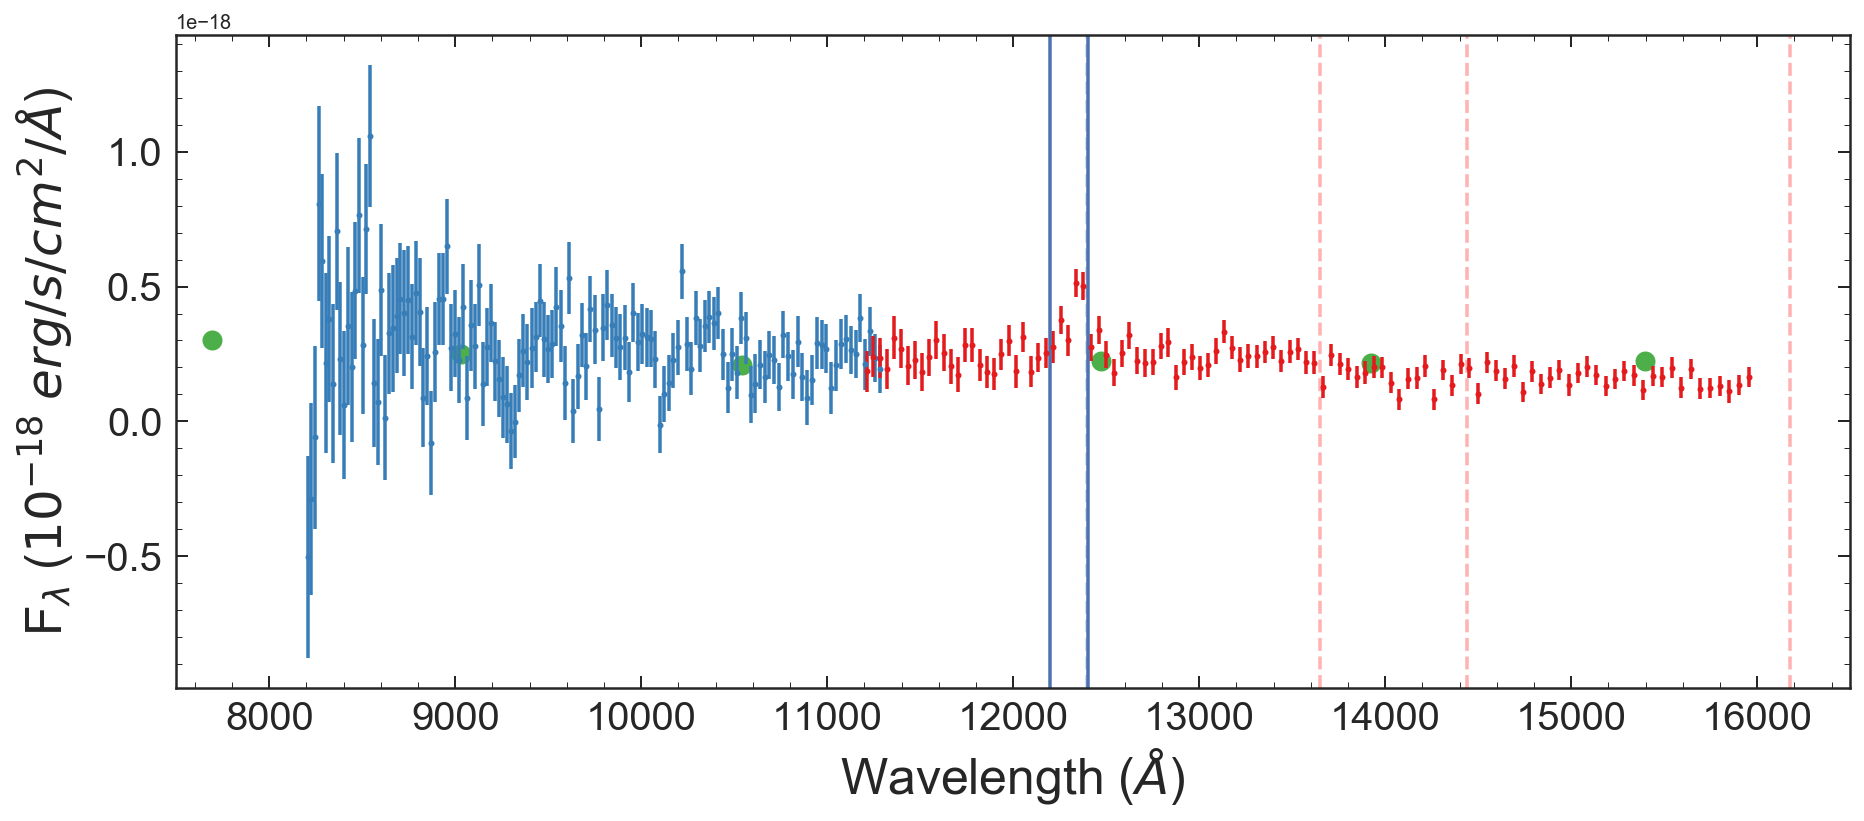

In [625]:
# rshift = 2.217
plt.figure(figsize = [15,6])
plt.errorbar(Gs.Bwv,Gs.Bfl,Gs.Ber,
                linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
plt.errorbar(Gs.Rwv,Gs.Rfl,Gs.Rer,
                linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')
plt.errorbar(Gs.Pwv,Gs.Pflx,Gs.Perr,
                linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')

plt.axvline(3727.092 * (1 + rshift),linestyle='--', alpha=.3)
plt.axvline(4102.89 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4341.68 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4862.68 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(5008.240 * (1 + rshift),linestyle='--', alpha=.3)
plt.axvline(6564.61 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(6718.29 * (1 + rshift),linestyle='--', alpha=.3, color = 'k')

plt.xlabel('Wavelength ($\AA$)', fontsize=25)
plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(7500,16500)

plt.axvline(12200)
plt.axvline(12400)
# plt.axvline(11200)
# plt.axvline(11900)
# plt.axvline(15200)
# plt.axvline(14400)
# plt.axvline(15000)
# plt.axvline(14000)
# plt.axvline(11900)
# plt.axvline(15200)

mask = [[12200,12400]]

IDMB = np.repeat(True, len(Gs.Bwv))
IDMR = np.repeat(True, len(Gs.Rwv))

for m in mask:
    for i in range(len(Gs.Bwv)):
        if m[0] < Gs.Bwv[i] < m[1]:
            IDMB[i] = False
    for i in range(len(Gs.Rwv)):
        if m[0] < Gs.Rwv[i] < m[1]:
            IDMR[i] = False
            
np.save('../Casey_data/spec/mask/{0}_{1}_mask'.format(field, gid), mask)

(7500, 16500)

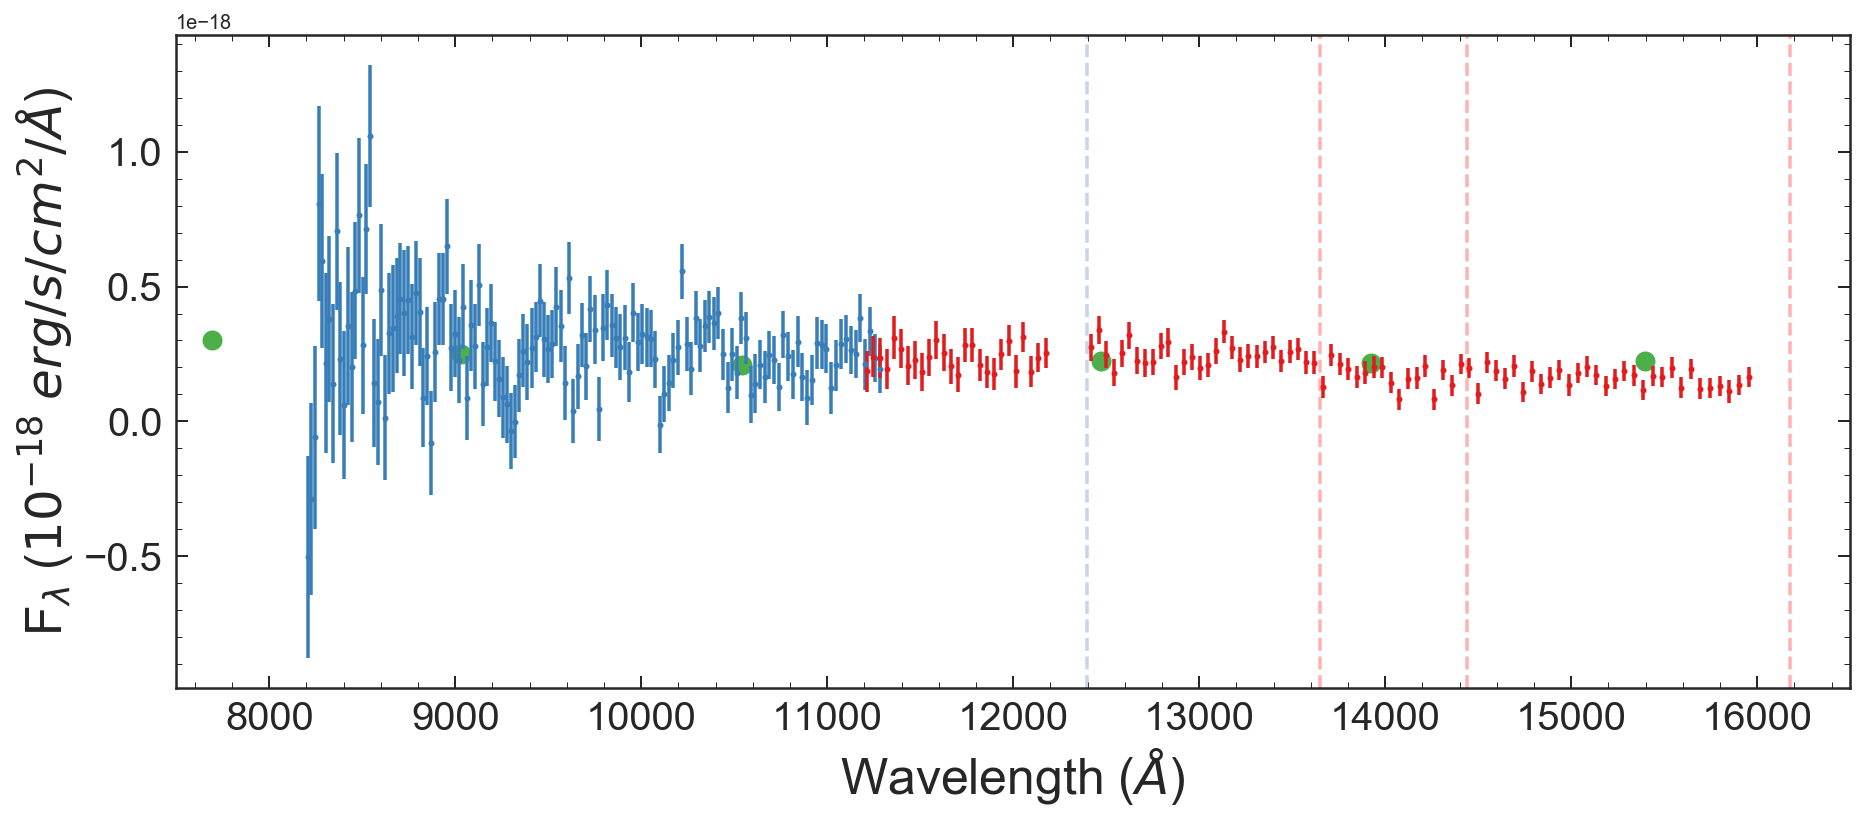

In [626]:
plt.figure(figsize = [15,6])
plt.errorbar(Gs.Bwv[IDMB],Gs.Bfl[IDMB],Gs.Ber[IDMB],
                linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
plt.errorbar(Gs.Rwv[IDMR],Gs.Rfl[IDMR],Gs.Rer[IDMR],
                linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')
plt.errorbar(Gs.Pwv,Gs.Pflx,Gs.Perr,
                linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')


plt.axvline(3727.092 * (1 + rshift),linestyle='--', alpha=.3)
plt.axvline(4102.89 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4341.68 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4862.68 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(5008.240 * (1 + rshift),linestyle='--', alpha=.3)
plt.axvline(6564.61 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(6718.29 * (1 + rshift),linestyle='--', alpha=.3, color = 'k')

plt.xlabel('Wavelength ($\AA$)', fontsize=25)
plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(7500,16500)

In [429]:
(rshift + 1) * 4862, 15048.946 / 5008 - 1

(15048.946147463235, 2.004981230031949)

In [552]:
rshift

1.958769329988846

# check spec

In [18]:
idx = 10

field='GSD'
gid = 41755

if field[1] == 'N':
    pre = 'N'
else:
    pre = 'S'

Gs = Gen_SF_spec(field, gid, 1,g102_lims=[8200, 11300], g141_lims=[11200, 16000])

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


(3000, 6500)

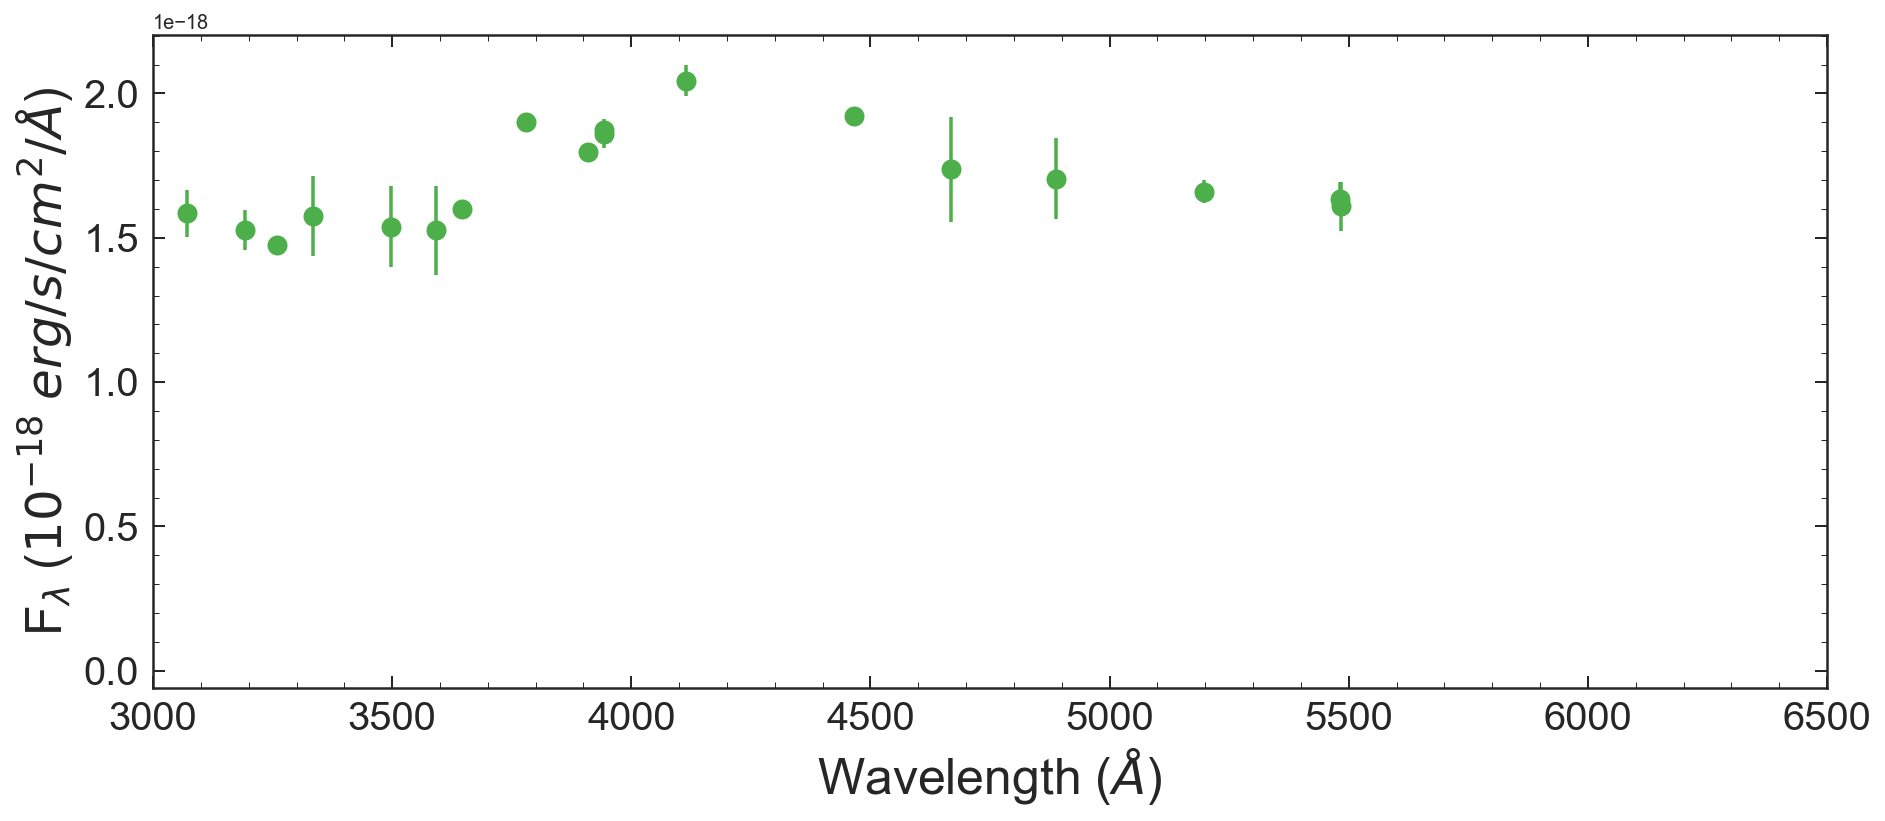

In [24]:
plt.figure(figsize = [15,6])
# plt.errorbar(Gs.Bwv,Gs.Bfl,Gs.Ber,
#                 linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
# plt.errorbar(Gs.Rwv,Gs.Rfl,Gs.Rer,
#                 linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')
plt.errorbar(Gs.Pwv/1.648,Gs.Pflx,Gs.Perr,
                linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')

plt.xlabel('Wavelength ($\AA$)', fontsize=25)
plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(3000,6500)


# Build master DF

In [10]:
C_GSD = pd.read_pickle('../Casey_data/massMetal_GSD.pkl')
C_GND = pd.read_pickle('../Casey_data/massMetal_GND.pkl')

20801 1.999846897835325 2.095217224899884
19235 1.342986118074703 1.43177122867351
21290 2.216623819968044 1.958769329988846


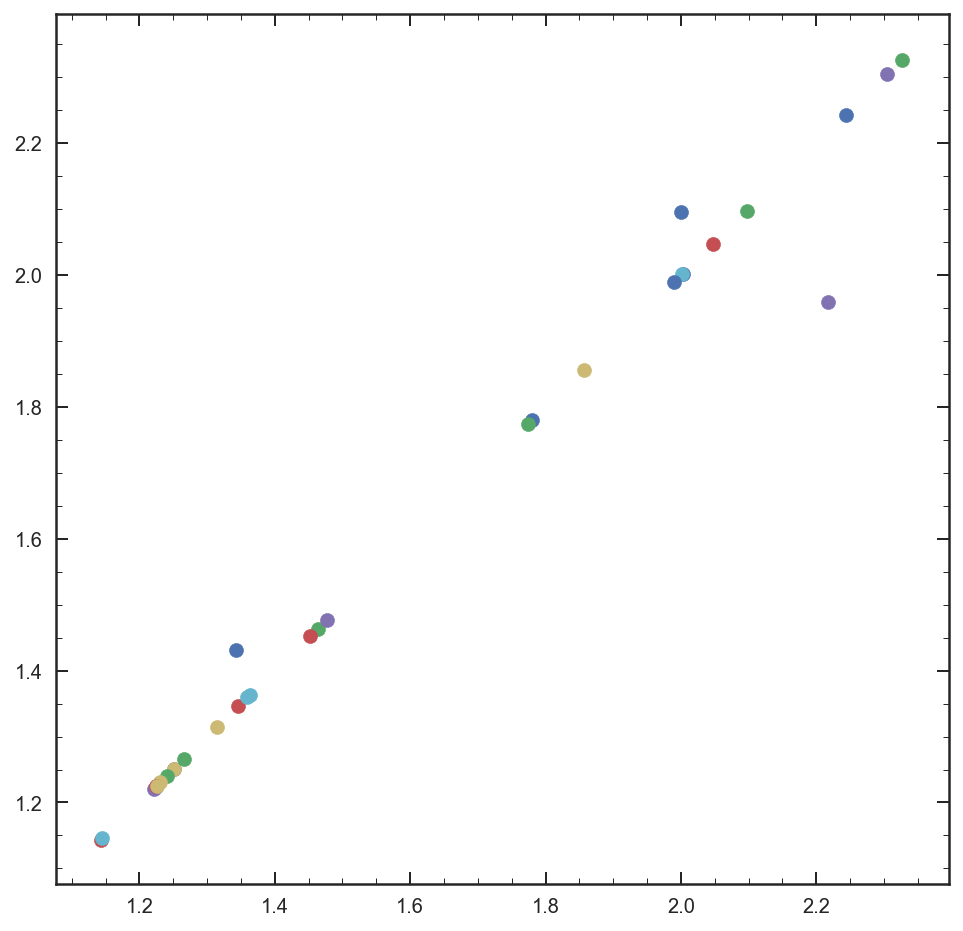

In [15]:
plt.figure(figsize=[8,8])
for i in C_GND.index:

    fp = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*{0}*/*{1}*'.format('N', C_GND.ID[i]))
    subfield = fp[0].split('/')[-2]
    dat = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/{0}_lines_grizli.fits'.format(subfield)), format='fits').to_pandas()
    rshift = dat.query('ID == {0}'.format(C_GND.ID[i])).z_50.values[0]
    
    plt.scatter(C_GND.z_50[i], rshift)
    
    if np.abs(C_GND.z_50[i] - rshift) > 0.01:
        print(C_GND.ID[i], C_GND.z_50[i], rshift)

In [29]:
C_GSD['z_50'][2857] = 0.648

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [30]:
C_GSD.query('ID == 41755').z_50

2857    0.648
Name: z_50, dtype: float64

In [36]:
C_GSD = C_GSD.drop_duplicates('ID')
C_GND = C_GND.drop_duplicates('ID')

In [43]:
C_GND = C_GND.query('ID != 24221')

In [44]:
ID_ALL = np.append(C_GND.ID.values, C_GSD.ID.values)
Z_ALL = np.append(C_GND.z_50.values, C_GSD.z_50.values)
FIELD = np.append(np.repeat('GND',len(C_GND.z_50.values)),np.repeat('GSD',len(C_GSD.z_50.values)))

In [47]:
SF_df = pd.DataFrame({'field':FIELD,'id':ID_ALL,'z':Z_ALL})

In [49]:
SF_df.to_pickle('../Casey_data/SF_db.pkl')

In [78]:
SF_df

,field,id,z
0,GND,35075,1.780320
1,GND,35204,2.096987
2,GND,28379,1.143402
3,GND,32719,1.250495
4,GND,30204,1.145387
5,GND,20801,1.999847
6,GND,11839,1.240109
7,GND,17927,1.346372
8,GND,17324,2.304721
9,GND,13777,1.231162


# test fit

In [80]:
dres = np.load('../data/out_dict/GND_19235_SFfit.npy').item()

bfm, bfa, bft, bflm, bfz, bfd, bfbp1, bfrp1, bfba, bfbb, bfbl, bfra, bfrb, bfrl = dres.samples[-1]

np.save('../data/bestfits/GND_19235_SFfit_bfit',
        [bfm, bfa,bft, bflm, bfz, bfd, bfbp1, bfrp1, bfba, bfbb, bfbl, bfra, bfrb, bfrl, dres.logl[-1]])

In [81]:
bfm, bfa, bft, bflm, bfz, bfd, bfbp1, bfrp1, bfba, bfbb, bfbl, bfra, bfrb, bfrl

(0.5540674389635866,
 1.7329916135873455,
 0.981371553089236,
 9.804908630774337,
 1.3193988727187367,
 0.08190930689513769,
 0.07036197870470705,
 0.0382026681790861,
 0.9864090944782492,
 0.06914989418238704,
 0.12249890805308399,
 0.986077981785397,
 0.08185800900499145,
 0.06376758319258484)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


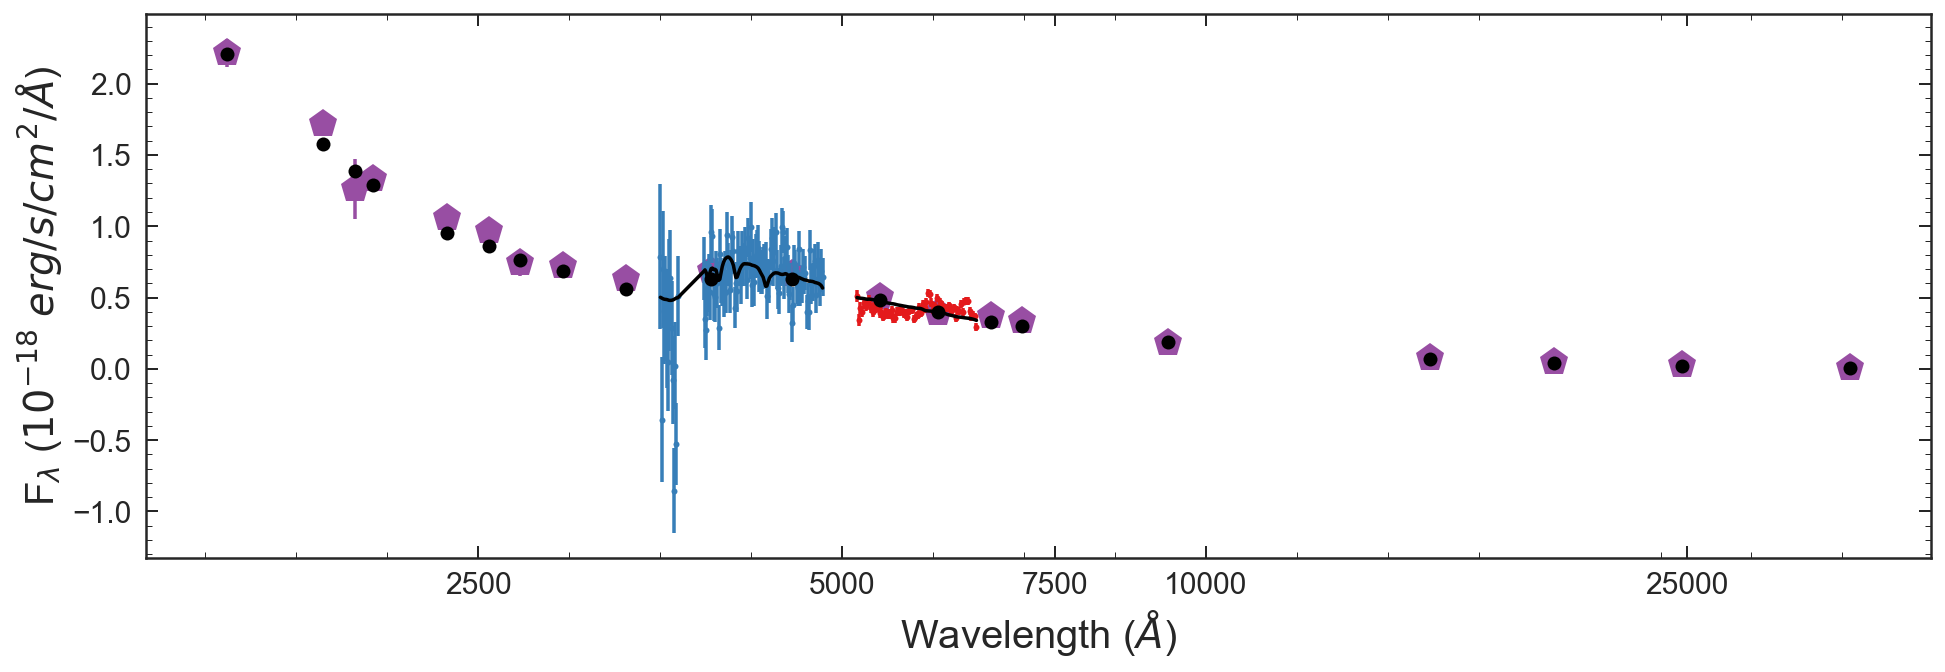

In [87]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 4, tau = 0.01, dust_type = 1)
m, a, tau, lm, z, d, bp1, rp1, ba, bb, bl, ra, rb, rl, logl = np.load(
    '../data/bestfits/GND_19235_SFfit_bfit.npy')

sp.params['dust2'] = d
sp.params['dust1'] = d
sp.params['logzsol'] = np.log10(m)
sp.params['tau'] = tau

wave, flux = sp.get_spectrum(tage = a, peraa = True)    

Gs = Gen_SF_spec('GND', 19235, z, g102_lims=[8200, 11300], g141_lims=[11200, 16000],
        phot_errterm = 0.04, irac_err = 0.08)
wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)

Gmfl, Pmfl = Full_forward_model(Gs, wave, F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm, z, 
                                    wvs, flxs, errs, beams, trans)
    
if Gs.g102:
    bcal = Calibrate_grism([wvs[0], flxs[0], errs[0]], Gmfl[0], bp1)[0]
    bscale = Scale_model( flxs[0] / bcal,errs[0]/ bcal,Gmfl[0])

if Gs.g141:
    rcal = Calibrate_grism([wvs[1], flxs[1], errs[1]], Gmfl[1], rp1)[0]
    rscale =Scale_model( flxs[1] / rcal,errs[1]/ rcal,Gmfl[1])

plt.figure(figsize=[16,5])

if Gs.g102:
    plt.errorbar(np.log10(Gs.Bwv_rf),flxs[0]*1E18 / bcal/bscale ,errs[0]*1E18 / bcal/bscale,
            linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
    plt.plot(np.log10(Gs.Bwv_rf),Gmfl[0]*1E18,'k', zorder = 4)

if Gs.g141:
    plt.errorbar(np.log10(Gs.Rwv_rf),flxs[1]*1E18 /  rcal /rscale,errs[1]*1E18 / rcal/rscale,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
    plt.plot(np.log10(Gs.Rwv_rf),Gmfl[1]*1E18,'k', zorder = 4)

plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
        linestyle='None', marker='p', markersize=15, color='#984ea3', zorder = 1)
plt.plot(np.log10(Gs.Pwv_rf),Pmfl*1E18,'ko', zorder = 3)
plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
plt.xlabel('Wavelength ($\AA$)', fontsize=20)
plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)


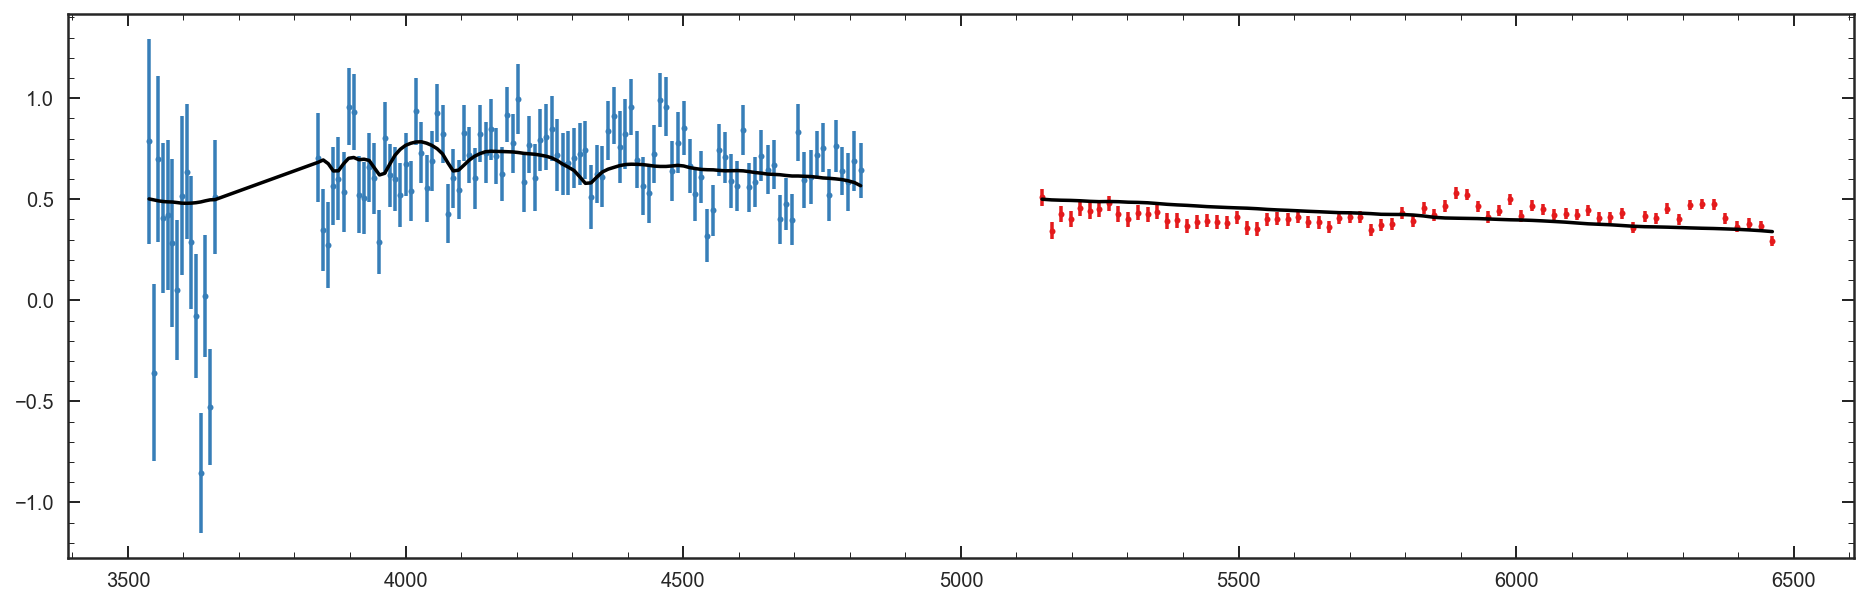

In [89]:
plt.figure(figsize=[16,5])

if Gs.g102:
    plt.errorbar(Gs.Bwv_rf,flxs[0]*1E18 / bcal/bscale ,errs[0]*1E18 / bcal/bscale,
            linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
    plt.plot(Gs.Bwv_rf,Gmfl[0]*1E18,'k', zorder = 4)

if Gs.g141:
    plt.errorbar(Gs.Rwv_rf,flxs[1]*1E18 /  rcal /rscale,errs[1]*1E18 / rcal/rscale,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
    plt.plot(Gs.Rwv_rf,Gmfl[1]*1E18,'k', zorder = 4)

(0, 0.0008)

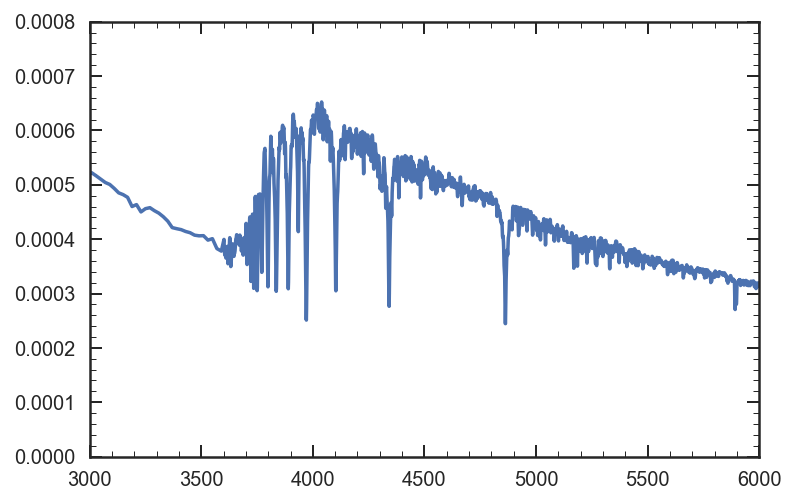

In [93]:
plt.plot(wave,flux)
plt.xlim(3000,6000)
plt.ylim(0,.0008)

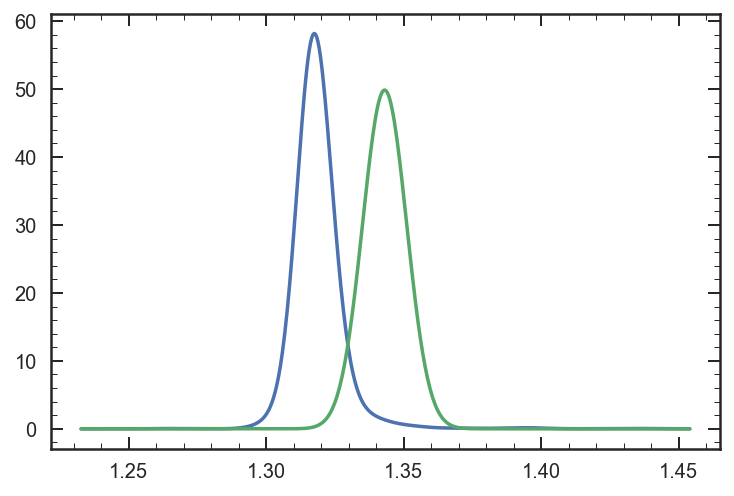

In [112]:
x,px = np.load('../data/posteriors/GND_19235_SFfit_Pz.npy')

plt.plot(x,px)
plt.plot(x, Gauss_dist(x,1.343,0.008))

In [100]:
 0.035 * (1 + 1.343)


0.08200500000000001

In [101]:
from spec_tools import Gauss_dist